## Preprocess Data for VAE

The aim of this notebook is to translate NetCDF files (.nc) of daily maximum temperature, latitude, and altitude, to a numpy 3D-array. This output array can easily be read for training and evaluating the Convolutional Variational AutoEncoder model.

#### 0. Libraries

In [1]:
import numpy as np
import xarray as xr
import cftime
import csv
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

#### 1. Load Data to xarrays

In [2]:
%%time

# Historical Datasets
# regrouped by climate variable

temp_50 = xr.open_dataset("../data/tasmax_day_CMCC-ESM2_historical_r1i1p1f1_gn_19500101-19741231.nc", chunks={"time": 365})
temp_75 = xr.open_dataset("../data/tasmax_day_CMCC-ESM2_historical_r1i1p1f1_gn_19750101-19991231.nc", chunks={"time": 365})
temp_00 = xr.open_dataset("../data/tasmax_day_CMCC-ESM2_historical_r1i1p1f1_gn_20000101-20141231.nc", chunks={"time": 365})
temp_histo = xr.concat([temp_50, temp_75, temp_00], "time")

CPU times: user 522 ms, sys: 344 ms, total: 865 ms
Wall time: 4.56 s


In [124]:
# Projection Datasets
# regrouped by climate variable

# choose IPCC scenario among 126, 245, 370, 585 (i.e. SSP1-2.6, ...)
scenario = '585'

temp_15 = xr.open_dataset(f"../data/tasmax_day_CMCC-ESM2_ssp{scenario}_r1i1p1f1_gn_20150101-20391231.nc", chunks={"time": 365})
temp_40 = xr.open_dataset(f"../data/tasmax_day_CMCC-ESM2_ssp{scenario}_r1i1p1f1_gn_20400101-20641231.nc", chunks={"time": 365})
temp_65 = xr.open_dataset(f"../data/tasmax_day_CMCC-ESM2_ssp{scenario}_r1i1p1f1_gn_20650101-20891231.nc", chunks={"time": 365})
temp_90 = xr.open_dataset(f"../data/tasmax_day_CMCC-ESM2_ssp{scenario}_r1i1p1f1_gn_20900101-21001231.nc", chunks={"time": 365})
temp_proj = xr.concat([temp_15, temp_40, temp_65, temp_90], "time")

In [4]:
# Projection Datasets
# regrouped by climate variable

# choose IPCC scenario among 126, 245, 370, 585 (i.e. SSP1-2.6, ...)
scenario = '245'

temp_40 = xr.open_dataset(f"../data/tasmax_day_CMCC-ESM2_ssp{scenario}_r1i1p1f1_gn_20400101-20641231.nc", chunks={"time": 365})
temp_65 = xr.open_dataset(f"../data/tasmax_day_CMCC-ESM2_ssp{scenario}_r1i1p1f1_gn_20650101-20891231.nc", chunks={"time": 365})
temp_90 = xr.open_dataset(f"../data/tasmax_day_CMCC-ESM2_ssp{scenario}_r1i1p1f1_gn_20900101-21001231.nc", chunks={"time": 365})
temp_proj = xr.concat([temp_40, temp_65], "time")
temp_proj = xr.concat([temp_proj, temp_90], "time")

In [5]:
# Load altitude

#orog = xr.open_dataset(f"../data/orog_ImonGre_CESM2_historical_r6i1p1f1_gn_185101-201512.nc", chunks={"time": 10})
sftlf = xr.open_dataset(f"../data/sftlf_fx_CESM2_historical_r9i1p1f1_gn.nc", chunks={"time": 10})

/scratch/globc/durif/annenv/xtclim/lib/python3.9/site-packages/xarray/conventions.py:432: SerializationWarning: variable 'sftlf' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


In [6]:
sftlf

<xarray.Dataset>
Dimensions:   (lat: 192, lon: 288, nbnd: 2)
Coordinates:
  * lat       (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon       (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Dimensions without coordinates: nbnd
Data variables:
    sftlf     (lat, lon) float32 dask.array<chunksize=(192, 288), meta=np.ndarray>
    lat_bnds  (lat, nbnd) float32 dask.array<chunksize=(192, 2), meta=np.ndarray>
    lon_bnds  (lon, nbnd) float32 dask.array<chunksize=(288, 2), meta=np.ndarray>
Attributes: (12/45)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    case_id:                23
    cesm_casename:          b.e21.BHIST.f09_g17.CMIP6-historical.009
    contact:                cesm_cmip6@ucar.edu
    creation_date:          2019-01-27T11:37:38Z
    ...                     ...
    variable_id:            sftlf
    variant_info:           CMIP6 20th century experiments (1850-2014) with C...
    variant_label:          r9i1p1f1
    branch_time_in_parent:  295650.0
    branch_time_in_child:   674885.0
    branch_method:          standard

#### 2. Restrict to a Geospatial Square

In [7]:
sq32_west_europe = {
    "min_lon": -10,
    "max_lon": 29,
    "min_lat": 36,
    "max_lat": 66
}

In [8]:
def xr_to_ndarray(xr_dset: xr.Dataset, 
                  sq_coords: dict
                 ) -> (np.ndarray, np.array, str):
    """
    Convert xarray dataset it to a cropped square ndarray.
    :param sq_coords: spatial coordinates of the crop
    """
    xr_dset.coords['lon'] = (xr_dset.coords['lon'] + 180) % 360 - 180
    xr_dset = xr_dset.sortby(xr_dset.lon)
    xr_dset = xr_dset.sel(
        lon = slice(sq_coords['min_lon'], sq_coords['max_lon']),
        lat = slice(sq_coords['min_lat'], sq_coords['max_lat'])
    )
    time_list = np.array(xr_dset['time'])
    n_t = len(time_list)
    n_lat = len(xr_dset.coords['lat'])
    n_lon = len(xr_dset.coords['lon'])
    nd_dset = np.ndarray((n_t, n_lat, n_lon, 1), dtype="float32")
    climate_variable = xr_dset.attrs['variable_id']
    nd_dset[:, :, :, 0] = xr_dset[climate_variable][:, :, :]
    nd_dset = np.flip(nd_dset, axis=1)
    
    return nd_dset, time_list

In [9]:
def sftlf_to_ndarray(xr_dset: xr.Dataset, 
                     sq_coords: dict
                    ) -> (np.ndarray, np.array, str):
    """
    Convert xarray dataset it to a cropped square ndarray.
    :param sq_coords: spatial coordinates of the crop
    """
    xr_dset.coords['lon'] = (xr_dset.coords['lon'] + 180) % 360 - 180
    xr_dset = xr_dset.sortby(xr_dset.lon)
    xr_dset = xr_dset.sel(
        lon = slice(sq_coords['min_lon'], sq_coords['max_lon']),
        lat = slice(sq_coords['min_lat'], sq_coords['max_lat'])
    )
    lat_list = xr_dset.coords['lat']
    lon_list = xr_dset.coords['lon']
    n_lat = len(lat_list)
    n_lon = len(lon_list)
    nd_dset = np.ndarray((n_lat, n_lon, 1), dtype="float32")
    climate_variable = xr_dset.attrs['variable_id']
    nd_dset[:, :, 0] = xr_dset[climate_variable][:, :]
    nd_dset = np.flipud(nd_dset) # flip upside down to have North up
    
    return nd_dset, lat_list, lon_list

In [10]:
# proportion from 0 to 100: normalize by 100
land_prop, lat_list, lon_list = sftlf_to_ndarray(sftlf, sq32_west_europe)
land_prop = land_prop/100

In [38]:
# create a latitude square array
norm_lat = (lat_list-min(lat_list))/(max(lat_list)-min(lat_list))
norm_lat = np.repeat(np.array(norm_lat), len(lon_list), axis=0)
norm_lat = norm_lat.reshape((32,32,1))

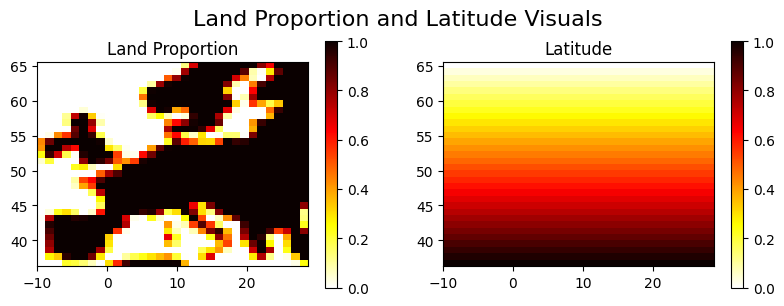

In [39]:
height = len(lat_list)/10
width = len(lon_list)/10

fig = plt.figure(figsize=(width*3, height))
fig.suptitle('Land Proportion and Latitude Visuals', fontsize=16)

ax_histo = fig.add_subplot(1, 2, 1)
ax_histo.set_title('Land Proportion')
cs = ax_histo.imshow(land_prop[:,:,0], cmap='hot_r', 
          extent=[lon_list[0], lon_list[-1], lat_list[0], lat_list[-1]], 
                     vmin=0, vmax=1) # fix the colorbar min and max
cbar = plt.colorbar(cs)

ax_proj = fig.add_subplot(1, 2, 2)
ax_proj.set_title('Latitude')
cs_norm = ax_proj.imshow(norm_lat[:,:,0], cmap='hot_r', 
          extent=[lon_list[0], lon_list[-1], lat_list[0], lat_list[-1]], 
                         vmin=0, vmax=1)
cbar_norm = plt.colorbar(cs_norm)

plt.show()

#### 3. Normalize

In [12]:
def get_extrema(histo_dataset: np.ndarray,
                proj_dataset: np.ndarray) -> np.array:
    # compute global extrema over past and future
    global_min = min(np.min(histo_dataset), np.min(proj_dataset))
    global_max = max(np.max(histo_dataset), np.max(proj_dataset))
    return np.array([global_min, global_max])

In [13]:
def normalize(nd_dset: np.ndarray, 
              extrema: np.array
             ) -> np.ndarray:
    norm_dset = (nd_dset-extrema[0])/(extrema[1]-extrema[0])
    return norm_dset

#### 4. Split Historical Data into Train and Test Datasets

Train the network on most of the historical data, but keep some to test the model performance on new data points.

In [14]:
def split_train_test(nd_dset: np.ndarray,
                     time_list: np.array,
                     train_proportion: float = 0.8
                    ) -> (np.ndarray, np.ndarray, np.array, np.array):
    len_train = int(len(nd_dset)*train_proportion)
    train_data = nd_dset[:len_train]
    test_data = nd_dset[len_train:]
    train_time = time_list[:len_train]
    test_time = time_list[len_train:]
    return train_data, test_data, train_time, test_time

#### 5. Combine into a 3D-Array

In [83]:
# reshape alt n_t times: to check

def ndarray_to_3d(temp_dset: np.ndarray,
                  land_prop,
                  norm_lat
                 ) -> np.ndarray:
    
    n_t = np.shape(temp_dset)[0]
    n_lat = np.shape(temp_dset)[1]
    n_lon = np.shape(temp_dset)[2]
    
    # combine all variables on a same period to a new 3D-array
    total_dset = np.zeros((n_t, n_lat, n_lon, 3), dtype="float32")
    total_dset[:,:,:,0] = temp_dset.reshape(n_t,n_lat,n_lon)
    total_dset[:,:,:,1] = np.transpose(np.repeat(land_prop, n_t, axis=2), axes=[2, 0, 1])
    total_dset[:,:,:,2] = np.transpose(np.repeat(norm_lat, n_t, axis=2), axes=[2, 0, 1])
    
    return total_dset

In [84]:
temp_histo_nd, time_list = xr_to_ndarray(temp_histo, sq32_west_europe)
temp_proj_nd, time_proj = xr_to_ndarray(temp_proj, sq32_west_europe)
extrema = get_extrema(temp_histo_nd, temp_proj_nd)
norm_hist = normalize(temp_histo_nd, extrema)
tot = ndarray_to_3d(norm_hist, land_prop, norm_lat)

#### 6. Full Preprocessing

In [88]:
def preprocess_1d(temp_histo: xr.Dataset,
                  temp_proj: xr.Dataset,
                  land_prop,
                  norm_alt,
                  sq_crop: dict,
                  saving_on: bool = True):
    
    # convert historical xarrays to ndarrays for each climate variable
    temp_histo_nd, time_list = xr_to_ndarray(temp_histo, sq_crop)

    # projection xarrays to ndarrays
    temp_proj_nd, time_proj = xr_to_ndarray(temp_proj, sq_crop)

    # compute extrema for each variable
    temp_extrema = get_extrema(temp_histo_nd, temp_proj_nd)

    # normalize all datasets
    temp_histo_norm = normalize(temp_histo_nd, temp_extrema)
    temp_proj_norm = normalize(temp_proj_nd, temp_extrema)

    # split historical datasets into train and test ones
    train_temp, test_temp, train_time, test_time = split_train_test(temp_histo_norm,
                                                                    time_list)

    # aggregate datasets per time period (3D-ndarrays)
    total_train = ndarray_to_3d(train_temp, land_prop, norm_alt)
    total_test = ndarray_to_3d(test_temp, land_prop, norm_alt)
    total_proj = ndarray_to_3d(temp_proj_norm, land_prop, norm_alt)

    # save data in input folder
    if saving_on == True:
        np.save("../input/preprocessed_1d_train_temp.npy", total_train)
        np.save("../input/preprocessed_1d_test_temp.npy", total_test)
        np.save("../input/preprocessed_1d_proj_temp.npy", total_proj)
        #pd.DataFrame(train_time).to_csv('../input/dates_train_data.csv')
        #pd.DataFrame(test_time).to_csv('../input/dates_test_data.csv')
        #pd.DataFrame(time_proj).to_csv('../input/dates_proj_data.csv')
        
    return total_train, total_test, total_proj, train_time, test_time, time_proj

In [89]:
total_train, total_test, total_proj, time_train, time_test, time_proj = preprocess_1d(temp_histo, temp_proj, 
                                                                                      land_prop, norm_lat,
                                                                                      sq32_west_europe, True)

#### 7. Step-by-Step Preprocessing

Here the functions are called one by one to analyze intermediate results or independently run small parts of the script.

In [99]:
temp_histo_nd, time_list = xr_to_ndarray(temp_histo, sq32_west_europe)
#prcp_histo_nd, _ = xr_to_ndarray(prcp_histo, sq32_west_europe)
#wind_histo_nd, _ = xr_to_ndarray(wind_histo, sq32_west_europe)

In [125]:
temp_proj_nd, time_proj = xr_to_ndarray(temp_proj, sq32_west_europe)
#prcp_proj_nd, _ = xr_to_ndarray(prcp_proj, sq32_west_europe)
#wind_proj_nd, _ = xr_to_ndarray(wind_proj, sq32_west_europe)

In [114]:
#temp_extrema = get_extrema(temp_histo_nd, temp_proj_nd)
#prcp_extrema = get_extrema(prcp_histo_nd, prcp_proj_nd)
#wind_extrema = get_extrema(wind_histo_nd, wind_proj_nd)
#extrema = np.array([temp_extrema, prcp_extrema, wind_extrema, temp_extrema, prcp_extrema, wind_extrema])

In [115]:
temp_extrema = np.array([234.8754, 327.64])
# ssp585 array([234.8754, 327.64  ], dtype=float32)
# ssp370 array([234.8754 , 325.43323], dtype=float32)
# ssp245 array([234.8754, 324.8263], dtype=float32)
# ssp126 array([234.8754, 323.6651], dtype=float32)

In [11]:
#prcp_extrema = np.array([0., 1.8359179e-03])
# ssp585 array([-7.8113006e-18,  1.4250991e-03], dtype=float32)
# ssp370 array([-7.7275618e-18,  1.8359179e-03], dtype=float32)
# ssp245 array([-1.3727080e-17,  1.6637903e-03], dtype=float32)
# ssp126 array([-5.3011077e-18,  1.5436712e-03], dtype=float32)

In [12]:
#wind_extrema = np.array([0.0441956, 29.883984])
# ssp585 array([ 0.0441956, 28.388906 ], dtype=float32)
# ssp370 array([ 0.0441956, 28.388906 ], dtype=float32)
# ssp245 array([0.0441956, 29.883984], dtype=float32)
# ssp126 array([ 0.0441956, 28.388906 ], dtype=float32)

In [102]:
temp_histo_norm = normalize(temp_histo_nd, temp_extrema)
#prcp_histo_norm = normalize(prcp_histo_nd, prcp_extrema)
#wind_histo_norm = normalize(wind_histo_nd, wind_extrema)

In [126]:
temp_proj_norm = normalize(temp_proj_nd, temp_extrema)
#prcp_proj_norm = normalize(prcp_proj_nd, prcp_extrema)
#wind_proj_norm = normalize(wind_proj_nd, wind_extrema)

In [104]:
train_temp, test_temp, train_time, test_time = split_train_test(temp_histo_norm,
                                                                time_list)
#train_prcp, test_prcp, _, _ = split_train_test(prcp_histo_norm, 
#                                               time_list)
#train_wind, test_wind, _, _ = split_train_test(wind_histo_norm,
#                                               time_list)

In [105]:
total_histo = ndarray_to_3d(temp_histo_norm, land_prop, norm_lat)

In [106]:
total_train = ndarray_to_3d(train_temp, land_prop, norm_lat)
total_test = ndarray_to_3d(test_temp, land_prop, norm_lat)

In [127]:
total_proj = ndarray_to_3d(temp_proj_norm, land_prop, norm_lat)

In [108]:
np.save("../input/preprocessed_1d_histo_data_allssp.npy", total_train)

In [109]:
np.save("../input/preprocessed_1d_train_data_allssp.npy", total_train)
np.save("../input/preprocessed_1d_test_data_allssp.npy", total_test)

In [128]:
np.save(f"../input/preprocessed_1d_proj{scenario}_data_allssp.npy", total_proj)

In [ ]:
pd.DataFrame(train_time).to_csv('../input/dates_train_data.csv')
pd.DataFrame(test_time).to_csv('../input/dates_test_data.csv')
pd.DataFrame(time_proj).to_csv('../input/dates_proj_data.csv')

#### 8. Preprocessing with 4 IPCC scenarios

In [9]:
temp_proj = []

scenarios = ['126', '245', '370', '585']
scenario = '126'
temp_40 = xr.open_dataset(f"../data/tasmax_day_CMCC-ESM2_ssp{scenario}_r1i1p1f1_gn_20400101-20641231.nc")
temp_65 = xr.open_dataset(f"../data/tasmax_day_CMCC-ESM2_ssp{scenario}_r1i1p1f1_gn_20650101-20891231.nc")
temp_90 = xr.open_dataset(f"../data/tasmax_day_CMCC-ESM2_ssp{scenario}_r1i1p1f1_gn_20900101-21001231.nc")
temp_proj.append(xr.concat([temp_40, temp_65, temp_90], "time"))

In [11]:
scenario = '245'

temp_40 = xr.open_dataset(f"../data/tasmax_day_CMCC-ESM2_ssp{scenario}_r1i1p1f1_gn_20400101-20641231.nc")
temp_65 = xr.open_dataset(f"../data/tasmax_day_CMCC-ESM2_ssp{scenario}_r1i1p1f1_gn_20650101-20891231.nc")
temp_90 = xr.open_dataset(f"../data/tasmax_day_CMCC-ESM2_ssp{scenario}_r1i1p1f1_gn_20900101-21001231.nc")
temp_proj.append(xr.concat([temp_40, temp_65, temp_90], "time"))

In [ ]:
scenario = '370'

temp_40 = xr.open_dataset(f"../data/tasmax_day_CMCC-ESM2_ssp{scenario}_r1i1p1f1_gn_20400101-20641231.nc")
temp_65 = xr.open_dataset(f"../data/tasmax_day_CMCC-ESM2_ssp{scenario}_r1i1p1f1_gn_20650101-20891231.nc")
temp_90 = xr.open_dataset(f"../data/tasmax_day_CMCC-ESM2_ssp{scenario}_r1i1p1f1_gn_20900101-21001231.nc")
temp_proj.append(xr.concat([temp_40, temp_65, temp_90], "time"))

In [1]:
scenario = '585'

temp_40 = xr.open_dataset(f"../data/tasmax_day_CMCC-ESM2_ssp{scenario}_r1i1p1f1_gn_20400101-20641231.nc")
temp_65 = xr.open_dataset(f"../data/tasmax_day_CMCC-ESM2_ssp{scenario}_r1i1p1f1_gn_20650101-20891231.nc")
temp_90 = xr.open_dataset(f"../data/tasmax_day_CMCC-ESM2_ssp{scenario}_r1i1p1f1_gn_20900101-21001231.nc")
temp_proj.append(xr.concat([temp_40, temp_65, temp_90], "time"))

NameError: name 'xr' is not defined

In [90]:
# Projection Datasets
# regrouped by climate variable

# IPCC scenarios: SSP1-2.6, SSP2-4.5, SSP3-7.0, SSP5-8.5
scenarios = ['126', '245', '370', '585']

temp_proj = []

for scenario in scenarios:

    temp_40 = xr.open_dataset(f"../data/tasmax_day_CMCC-ESM2_ssp{scenario}_r1i1p1f1_gn_20400101-20641231.nc", 
                              chunks={"time": 365})
    temp_65 = xr.open_dataset(f"../data/tasmax_day_CMCC-ESM2_ssp{scenario}_r1i1p1f1_gn_20650101-20891231.nc", 
                              chunks={"time": 365})
    temp_90 = xr.open_dataset(f"../data/tasmax_day_CMCC-ESM2_ssp{scenario}_r1i1p1f1_gn_20900101-21001231.nc", 
                              chunks={"time": 365})
    temp_proj.append(xr.concat([temp_40, temp_65, temp_90], "time"))

In [91]:
def get_global_extrema(histo_dataset: np.ndarray,
                       proj_list: list[np.ndarray]) -> np.array:
    # compute global extrema over past and future
    global_min = np.min(histo_dataset)
    global_max = np.max(histo_dataset)
    for i in range(len(proj_list)):
        global_min = min(global_min, np.min(proj_list[i]))
        global_max = max(global_max, np.max(proj_list[i]))
    return np.array([global_min, global_max])

In [96]:
extrema = get_global_extrema(temp_histo, temp_proj)

TypeError: cannot directly convert an xarray.Dataset into a numpy array. Instead, create an xarray.DataArray first, either with indexing on the Dataset or by invoking the `to_dataarray()` method.

In [92]:
def preprocess_1d_allssp(temp_histo: xr.Dataset,
                         temp_proj: list[xr.Dataset],
                         land_prop,
                         norm_lat,
                         sq_crop: dict,
                         scenarios: list[str],
                         saving_on: bool = True):
    
    n_ipcc = len(scenarios)
    
    # convert historical xarrays to ndarrays for each climate variable
    temp_histo_nd, time_list = xr_to_ndarray(temp_histo, sq_crop)

    temp_proj_list = []
    _, time_proj = xr_to_ndarray(temp_proj[0], sq_crop)
    for i in range(n_ipcc):
        # projection xarrays to ndarrays
        temp_proj_list = temp_proj_list.append(xr_to_ndarray(temp_proj[i], sq_crop)[0])

    # compute extrema for each variable
    temp_extrema = get_global_extrema(temp_histo_nd, temp_proj_list)

    # normalize all datasets
    temp_histo_norm = normalize(temp_histo_nd, temp_extrema)
    temp_proj_norm = []
    total_proj = []
    for i in range(n_ipcc):
        temp_norm = normalize(temp_proj_nd, temp_extrema)
        temp_proj_norm = temp_proj_norm.append(temp_norm)
        # aggregate
        total_proj = total_proj.append(ndarray_to_3d(temp_norm,
                                                     land_prop,
                                                     norm_lat))

    # split historical datasets into train and test ones
    train_temp, test_temp, train_time, test_time = split_train_test(temp_histo_norm,
                                                                    time_list)
    # aggregate datasets per time period (3D-ndarrays)
    total_train = ndarray_to_3d(train_temp, land_prop, norm_lat)
    total_test = ndarray_to_3d(test_temp, land_prop, norm_lat)

    # save data in input folder
    if saving_on == True:
        np.save("../input/preprocessed_3d_train_data.npy", total_train)
        np.save("../input/preprocessed_3d_test_data.npy", total_test)
        pd.DataFrame(train_time).to_csv('../input/dates_train_data.csv')
        pd.DataFrame(test_time).to_csv('../input/dates_test_data.csv')
        pd.DataFrame(time_proj).to_csv('../input/dates_proj_data.csv')
        for i in range(n_ipcc):
            np.save(f"../input/preprocessed_3d_proj{scenarios[i]}_data.npy", total_proj[i])
        
    return total_train, total_test, total_proj, train_time, test_time, time_proj

In [95]:
preprocess_1d_allssp(temp_histo, temp_proj, land_prop, norm_lat,
                     sq32_west_europe, scenarios, False)

AttributeError: 'NoneType' object has no attribute 'append'

In [22]:
_, time_proj = xr_to_ndarray(temp_proj, sq32_west_europe)
pd.DataFrame(time_proj).to_csv('../input/dates_proj_data.csv')